Dropout statistics data analyis
=====
This notebook summarizes the efforts made in the analysis of statistical dropout data for the standard 4130cu. in. array with Bolt LLXT guns. Other arrays or dropout rules may easily be analyzed by saving this Jupyter Notebook with a new name and feed in the raw statistics (dan) files for the relavant source. Dropout rules are specified in this notebook under the Heading called Dropout Rule.

## Motivation
Dropout specs and modeling has been a topic for discussion for years:
The tolerance specs are sharp, resulting in a red or green box in a dropout matrix, but the matrix is based on a set of assumptions that are quite inaccurate.

<li>Source modeling code and calibration: old vs new matters</li>

<li>Temperature sensitivity</li>

<li>We are assuming a static and 100% correctly deployed source.</li>

<li>Dropouts are done on vertical farfields, even if relevant farfields are mostly non-vertical</li>

<li>Origin of specs (operational more than geophysical, “nice round numbers”).</li>

<li>Etc.</li>

Reshoots due to dropouts are costly. A revision is in line with a streamlining/cost-cutting philosophy
There is no guarantee that a reshoot results in improved data quality
Current practice of bespoke dropout matrix per project is error prone and resource demanding. And triggers discussion if new modeling should be used to allow for more dropped guns.

Shot-to-shot designature: Some possibility to correct for a range of bad shots.

Include perl script

# Importing modules for plotting

In [387]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Setting some parameters for reading the input


Below, the header of two dan-files (broadband and conventional/cross-correlation) are listed to confirm the modeling parameters used in Nucleus. First specify the path to the dan files for the dataset to analyze:

In [388]:
path = "./batch_4130_alt2_substitution_modeling/"

In [389]:
file = "4130T__040_080_00_5.dan"
f = open(path + "bb_" + file)
lines = f.read().splitlines()
f.close()
for i, line in enumerate(lines):
    if i < 56:
        print(i, line)


0 DROPOUT SIGNATURE STATISTICS :
1 
2 Project : 2018_06_MasterMatrix
3 Dataset : 1drop_sparesub
4 
5 File format number   : 8
6 Statistics created by Nucleus+ version 2.7.1
7 Statistics created by Marine source modelling version 1.11.1
8 
9 User reference       : 
10 
11 Computed dropout signature statistics.
12 Correlation measure  : NA.
13 
14 Project name               : 2018_06_MasterMatrix
15 Dropout signature dataset  : 1drop_sparesub
16 Dropout array name         : 4130T__040_2000_080_00
17 Reference array name       : 4130T__040_2000_080_alt2
18 Instrument filter          : GeoStr LChyd_3/7-214/341
19 
20 Frequency analysis option  : Average absolute spectral deviation.
21 Bandwidth of analysis (Hz) :   5.00  -  200.00
22 
23 Sampling interval (ms)     :      0.50
24 Water velocity (m/s)       :   1470.91
25 Water temperature (C)      :      5.00
26 Notional refl. coeff       :     -1.00
27 Farfield refl. coeff       :      0.00
28 Farfield dip angle (deg)   :      0.00
29 Farf

In [390]:
file = "4130T__040_080_00_5.dan"
f = open(path + "cc_" + file)
lines = f.read().splitlines()
f.close()
for i, line in enumerate(lines):
    if i < 56:
        print(i, line)


0 DROPOUT SIGNATURE STATISTICS :
1 
2 Project : 2018_06_MasterMatrix
3 Dataset : 1drop_sparesub_cc
4 
5 File format number   : 8
6 Statistics created by Nucleus+ version 2.7.1
7 Statistics created by Marine source modelling version 1.11.1
8 
9 User reference       : 
10 
11 Computed dropout signature statistics.
12 Correlation measure  : Cross correlation.
13 
14 Project name               : 2018_06_MasterMatrix
15 Dropout signature dataset  : 1drop_sparesub_cc
16 Dropout array name         : 4130T__040_2000_080_00
17 Reference array name       : 4130T__040_2000_080_alt2
18 Instrument filter          : GeoStr LChyd_3/7-214/341
19 
20 Primary pick window (ms)   : -68.50  -   30.00
21 Bubble pick mode           : Manual
22 Bubble pick window (ms)    :  50.00  -  200.00
23 
24 Amplitude option           : Positive peak amplitude.
25 Frequency analysis option  : Average absolute spectral deviation.
26 Bandwidth of analysis (Hz) :  10.00  -   70.00
27 
28 Sampling interval (ms)     :      0

Setting the numbers of lines to skip. This is for the 4130 array.

In [391]:
#bb statistics
onegunskip = 42
spareskip = 74
eof = 92

#conventional statistics
onegunskipcc = 54
spareskipcc = 86
eofcc = 104

arrayvol = '4130T'
arraydepth = [4, 5, 6, 7, 8, 9]
subsep = [8, 10]
temp = [5, 10, 15, 20, 25]
prefix = ['bb', 'cc']
substscenario = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17']

Setting file name

In [392]:
filenames = []

for a in arraydepth:
    for s in subsep:
        for subst in substscenario:
            for t in temp:
                if s < 10:
                    filenames.append(arrayvol + '__0' + str(a) + '0_0' + str(s) + '0_' + subst + "_" + str(t) + '.dan')
                else:
                    filenames.append(arrayvol + '__0' + str(a) + '0_' + str(s) + '0_' + subst + "_" + str(t) + '.dan')

Just checking the file names:

In [393]:
count = 0
for filename in filenames:
    if count < 10:
        print(filename)
    count += 1
print(len(filenames))

4130T__040_080_00_5.dan
4130T__040_080_00_10.dan
4130T__040_080_00_15.dan
4130T__040_080_00_20.dan
4130T__040_080_00_25.dan
4130T__040_080_01_5.dan
4130T__040_080_01_10.dan
4130T__040_080_01_15.dan
4130T__040_080_01_20.dan
4130T__040_080_01_25.dan
1080


## Modeling Parameters
This report analyse statistical values of the following dropout scenarios:
<li>Temperatures: 5, 10, 15, 20, 25</li>
<li>Depths 4-9m; 1m increment</li>
<li>Subarray separation: 8 and 10m</li>
<li>Bolt and GII guns</li>
<li>Broadband (refl coeff zero) and conventional (refl coeff -1)</li>
Total: 123 360 combinations
<li>60 source/temperature combinations</li>
<li>2 modelings per source (broadband and conv)</li>
<li>2 gun types</li>
<li>All single and two gun dropouts with spare gun substitution</li>
<li>514 dropout combinations per source (nominal source always used as reference)</li>

The datasets are analyzed separately for Gun type to detect systematic differences.


Defining the column names:

In [394]:
columns_one_gun_bb_raw = ['droparray1', 'dropgun1', 'gunvolume1', 'AvgdB', 'MaxdB', 'MaxPhase']
columns_spare_gun_bb_raw = ['droparray1', 'dropgun1', 'droparray2', 'dropgun2', 'gunvolume1', 'gunvolume2', 'AvgdB', 'MaxdB', 'MaxPhase']	
columns_one_gun_cc_raw = ['droparray1', 'dropgun1', 'gunvolume1', 'Peak', 'Peakch','PtoB','PtoBch', 'x-corr', 'AvgdB', 'MaxdB']
columns_spare_gun_cc_raw = ['droparray1', 'dropgun1', 'droparray2', 'dropgun2', 'gunvolume1', 'gunvolume2', 'Peak', 'Peakch', 'PtoB', 'PtoBch', 'x-corr', 'AvgdB', 'MaxdB']

Statistical data defined as panda dataframes:

In [395]:
stat_one_gun_bb_raw = pd.DataFrame()
stat_spare_gun_bb_raw = pd.DataFrame()
stat_one_gun_cc_raw = pd.DataFrame()
stat_spare_gun_cc_raw = pd.DataFrame()

Reading data from files into dataframes:

In [396]:
for filename in filenames:
    temp_stat_one_gun_bb_raw = pd.read_csv(path + 'bb_' + filename, names=columns_one_gun_bb_raw, skiprows=onegunskip, delim_whitespace=True, nrows=spareskip-onegunskip)
    temp_stat_one_gun_bb_raw['filename'] = filename
    temp_stat_one_gun_bb_raw['Depth'] = int(filename[7:10])
    temp_stat_one_gun_bb_raw['Subsep'] = int(filename[11:14])
    temp_stat_one_gun_bb_raw['Substscenario'] = filename[15:17]
    temp_stat_one_gun_bb_raw['Temperature'] = int(filename[18:20].replace('.',''))
    stat_one_gun_bb_raw = stat_one_gun_bb_raw.append(temp_stat_one_gun_bb_raw)
    temp_stat_one_gun_bb_raw = []
   
    temp_stat_spare_gun_bb_raw = pd.read_csv(path + 'bb_' + filename, names=columns_spare_gun_bb_raw, skiprows=spareskip, delim_whitespace=True, nrows=eof-spareskip)
    temp_stat_spare_gun_bb_raw['filename'] = filename
    temp_stat_spare_gun_bb_raw['Depth'] = int(filename[7:10])
    temp_stat_spare_gun_bb_raw['Subsep'] = int(filename[11:14])
    temp_stat_spare_gun_bb_raw['Substscenario'] = filename[15:17]
    temp_stat_spare_gun_bb_raw['Temperature'] = int(filename[18:20].replace('.',''))
    stat_spare_gun_bb_raw = stat_spare_gun_bb_raw.append(temp_stat_spare_gun_bb_raw)
    temp_stat_spare_gun_bb_raw = []
    
    temp_stat_one_gun_cc_raw = pd.read_csv(path + 'cc_' + filename, names=columns_one_gun_cc_raw, skiprows=onegunskipcc, delim_whitespace=True, nrows=spareskipcc-onegunskipcc)
    temp_stat_one_gun_cc_raw['filename'] = filename
    temp_stat_one_gun_cc_raw['Depth'] = int(filename[7:10])
    temp_stat_one_gun_cc_raw['Subsep'] = int(filename[11:14])
    temp_stat_one_gun_cc_raw['Substscenario'] = filename[15:17]
    temp_stat_one_gun_cc_raw['Temperature'] = int(filename[18:20].replace('.',''))
    stat_one_gun_cc_raw = stat_one_gun_cc_raw.append(temp_stat_one_gun_cc_raw)
    temp_stat_one_gun_cc_raw = []

    temp_stat_spare_gun_cc_raw = pd.read_csv(path + 'cc_' + filename, names=columns_spare_gun_cc_raw, skiprows=spareskipcc, delim_whitespace=True, nrows=eofcc-spareskipcc)
    temp_stat_spare_gun_cc_raw['filename'] = filename
    temp_stat_spare_gun_cc_raw['Depth'] = int(filename[7:10])
    temp_stat_spare_gun_cc_raw['Subsep'] = int(filename[11:14])
    temp_stat_spare_gun_cc_raw['Substscenario'] = filename[15:17]
    temp_stat_spare_gun_cc_raw['Temperature'] = int(filename[18:20].replace('.',''))
    stat_spare_gun_cc_raw = stat_spare_gun_cc_raw.append(temp_stat_spare_gun_cc_raw)
    temp_stat_spare_gun_cc_raw = []

The follwing is a lambda function that converts to string and adds zeros to a total length of 2 characters to the input x (which could be an int). Is later used to convert all gun numbers from int to string. (3 to "03", for example)

In [397]:
add_zero = lambda x: str(int(x)).zfill(2)

Adding all the string representations for gun numbering in a dedicated set of columns. Is later used to make array_gun_number index with a logical order. 

In [398]:
stat_one_gun_bb_raw['dropgun1_str'] = stat_one_gun_bb_raw['dropgun1'].apply(add_zero)
stat_spare_gun_bb_raw['dropgun1_str'] = stat_spare_gun_bb_raw['dropgun1'].apply(add_zero)
stat_spare_gun_bb_raw['dropgun2_str'] = stat_spare_gun_bb_raw['dropgun2'].apply(add_zero)
stat_one_gun_cc_raw['dropgun1_str'] = stat_one_gun_cc_raw['dropgun1'].apply(add_zero)
stat_spare_gun_cc_raw['dropgun1_str'] = stat_spare_gun_bb_raw['dropgun1'].apply(add_zero)
stat_spare_gun_cc_raw['dropgun2_str'] = stat_spare_gun_bb_raw['dropgun2'].apply(add_zero)

Printing some statistics to check that dataframes are ok (Remove hash for what you want to print)

In [399]:
#print('stat_one_gun_bb_raw: ')
print(stat_one_gun_bb_raw.head())
#print(stat_one_gun_bb_raw.head())
#print(stat_one_gun_bb_raw.tail())
#print(stat_one_gun_cc_raw)
#print(stat_two_gun_bb_raw.info())
#print('stat_spare_gun')

#print(stat_one_gun_cc_raw.head())
#print(stat_one_gun_cc_raw.tail())
#print('stat_two_gun_cc_raw: ')
#print(stat_two_gun_cc_raw.head())
#print(stat_two_gun_cc_raw.info())
# print('stat_spare_gun_cc_raw')
print(stat_spare_gun_bb_raw.tail())
# print(stat_spare_gun_cc_raw.info())
#print(len(stat_one_gun_bb_raw), len(stat_two_gun_bb_raw), len(stat_spare_gun_bb_raw))
#print(len(stat_one_gun_cc_raw), len(stat_two_gun_cc_raw), len(stat_spare_gun_cc_raw))

   droparray1  dropgun1  gunvolume1  AvgdB  MaxdB  MaxPhase  \
0           0         0           0   0.10    1.7       8.2   
1           1         2         150   0.39    2.3      11.1   
2           1         3         150   0.27    2.0      14.1   
3           1         4         150   0.27    2.1      14.4   
4           1         5          40   0.21    1.7       8.5   

                  filename  Depth  Subsep Substscenario  Temperature  \
0  4130T__040_080_00_5.dan     40      80            00            5   
1  4130T__040_080_00_5.dan     40      80            00            5   
2  4130T__040_080_00_5.dan     40      80            00            5   
3  4130T__040_080_00_5.dan     40      80            00            5   
4  4130T__040_080_00_5.dan     40      80            00            5   

  dropgun1_str  
0           00  
1           02  
2           03  
3           04  
4           05  
    droparray1  dropgun1  droparray2  dropgun2  gunvolume1  gunvolume2  AvgdB  \
13   

Next step is to copy dataframes to identical copy with "all" postfix. Then later, the mastermatrix filter will be applied to the original dataframes. The "all" dataframes will contain the unfiltered data material.

In [400]:
stat_one_gun_bb_legal = stat_one_gun_bb_raw
stat_spare_gun_bb_legal = stat_spare_gun_bb_raw
stat_one_gun_cc_legal = stat_one_gun_cc_raw
stat_spare_gun_cc_legal = stat_spare_gun_cc_raw

## Dropout Rule
Master Matrix suggestion:
<li>Illegal dropouts are defined by operationally suitable gun combinations and not by “geophysical” specs:</li>

<li>All substitutions allowed</li>

<li>Same rule applied regardless of depth, gun type, subarray separation, temperature.</li>

<li>We probably have to live with some outliers (keep shooting in some of the red boxes). This notebook investigates the impact on a statistical level.</li>

The goal for the new dropout rule is:
<b>“No single gun dropout is a show- stopper. All failing big guns in clusters may be substituted”</b>

### Master Matrix definition and filtering of dataset
Here comes the master matrix definition and filtering:

In [401]:
illegal_one_gun = [
#                   [1, 1],
#                   [1, 2],
#                   [1, 3],
#                   [1, 4],
                   [1, 13],
				   [1, 14],
#                   [2, 11],
#                   [2, 12],
				   [3, 1],
				   [3, 2], 
                   [3, 11], 
				   [3, 12],
				   [3, 13],
				   [3, 14],
#                   [1, 9], #These are single guns that can be set illegal since they can be substituted.
#                   [2, 1],
#                   [2, 9],
                   [2, 13] #250 Single
                  ]
for i in range(len(illegal_one_gun)):
	stat_one_gun_bb_legal = stat_one_gun_bb_legal.drop(stat_one_gun_bb_legal[(stat_one_gun_bb_legal.droparray1 == illegal_one_gun[i][0]) & (stat_one_gun_bb_legal.dropgun1 == illegal_one_gun[i][1])].index) 
	stat_one_gun_cc_legal = stat_one_gun_cc_legal.drop(stat_one_gun_cc_legal[(stat_one_gun_cc_legal.droparray1 == illegal_one_gun[i][0]) & (stat_one_gun_cc_legal.dropgun1 == illegal_one_gun[i][1])].index)



In [402]:
print(stat_spare_gun_bb_legal.columns)
print(stat_spare_gun_bb_legal.head(20))

Index(['droparray1', 'dropgun1', 'droparray2', 'dropgun2', 'gunvolume1',
       'gunvolume2', 'AvgdB', 'MaxdB', 'MaxPhase', 'filename', 'Depth',
       'Subsep', 'Substscenario', 'Temperature', 'dropgun1_str',
       'dropgun2_str'],
      dtype='object')
    droparray1  dropgun1  droparray2  dropgun2  gunvolume1  gunvolume2  AvgdB  \
0            1         2           1        -1         150         150   0.10   
1            1         3           1        -1         150         150   0.12   
2            1         4           1        -1         150         150   0.12   
3            2         1           1        -1         150         150   0.00   
4            2         2           1        -1         150         150   0.00   
5            3         1           1        -1         150         150   0.07   
6            3         2           1        -1         150         150   0.07   
7            1         9           1       -10         100         100   0.10   
8            2 

Setting a rule for illegal spare substitution:

In [403]:
#illegal_spare = [[[1, 1], [3, -4]], 
#                 [[1, 2], [3, -4]]]
#
#for i in range(len(illegal_spare)):
#    print(illegal_spare[i][0][0], illegal_spare[i][0][1], illegal_spare[i][1][0], illegal_spare[i][1][1])
#    stat_spare_gun_bb_legal = stat_spare_gun_bb_legal.drop\
#    (stat_spare_gun_bb_legal[((stat_spare_gun_bb_legal.droparray1 == illegal_spare[i][0][0]) & (stat_spare_gun_bb_legal.dropgun1 == illegal_spare[i][0][1]))].index)
#    stat_spare_gun_cc_legal = stat_spare_gun_cc_legal.drop\
#    (stat_spare_gun_cc_legal[((stat_spare_gun_cc_legal.droparray1 == illegal_spare[i][0][0]) & (stat_spare_gun_cc_legal.dropgun1 == illegal_spare[i][0][1]))].index)                                                                                   
                                                                                       
                                                                                       

In [404]:
print("Number of combinations for all(raw) combinations (one gun and spare)")
print(len(stat_one_gun_bb_raw), len(stat_spare_gun_bb_raw))
print(len(stat_one_gun_cc_raw), len(stat_spare_gun_cc_raw))
print("Number of combinations for legal combinations (one gun and spare)")
print(len(stat_one_gun_bb_legal), len(stat_spare_gun_bb_legal))
print(len(stat_one_gun_cc_legal), len(stat_spare_gun_cc_legal))

Number of combinations for all(raw) combinations (one gun and spare)
34560 19440
34560 19440
Number of combinations for legal combinations (one gun and spare)
20520 19440
20520 19440


Taking out "bad" dropout substitution scenarios from the dataset:

In [405]:
#stat_one_gun_bb_legal = stat_one_gun_bb_legal.loc[stat_one_gun_bb_legal['Substscenario'] != "00"]
#stat_one_gun_bb_legal = stat_one_gun_bb_legal.loc[stat_one_gun_bb_legal['Substscenario'] != "01"]

#stat_one_gun_cc_legal = stat_one_gun_cc_legal.loc[stat_one_gun_cc_legal['Substscenario'] != "00"]
#stat_one_gun_cc_legal = stat_one_gun_cc_legal.loc[stat_one_gun_cc_legal['Substscenario'] != "01"]

In [406]:
#stat_spare_gun_bb_legal = stat_spare_gun_bb_legal.loc[stat_spare_gun_bb_legal['Substscenario'] != "00"]
#stat_spare_gun_bb_legal = stat_spare_gun_bb_legal.loc[stat_spare_gun_bb_legal['Substscenario'] != "01"]

#stat_spare_gun_cc_legal = stat_spare_gun_cc_legal.loc[stat_spare_gun_cc_legal['Substscenario'] != "00"]
#stat_spare_gun_cc_legal = stat_spare_gun_cc_legal.loc[stat_spare_gun_cc_legal['Substscenario'] != "01"]

In [407]:
print("Number of combinations for all(raw) combinations (one gun and spare)")
print(len(stat_one_gun_bb_raw), len(stat_spare_gun_bb_raw))
print(len(stat_one_gun_cc_raw), len(stat_spare_gun_cc_raw))
print("Number of combinations for legal combinations (one gun and spare)")
print(len(stat_one_gun_bb_legal), len(stat_spare_gun_bb_legal))
print(len(stat_one_gun_cc_legal), len(stat_spare_gun_cc_legal))

Number of combinations for all(raw) combinations (one gun and spare)
34560 19440
34560 19440
Number of combinations for legal combinations (one gun and spare)
20520 19440
20520 19440


Here comes the functions that do the matplotlib plots:

In [461]:
def figplot(figno, dataset_bb_all, dataset_bb, dataset_cc_all, dataset_cc, figtitle):
    plt.figure(figno, figsize=(16, 12))
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.suptitle(figtitle, fontsize=16)
    plt.subplot(321)
    plt.hist(dataset_bb_all['MaxPhase'], bins=40, range=(0, 40), alpha=0.4, label='all')
    plt.hist(dataset_bb['MaxPhase'], bins=40, range=(0, 40), alpha=0.4, label='legal')
    plt.axvline(x=20)
    plt.legend()
    plt.title('MaxPhase')

    plt.subplot(323)
    plt.hist(dataset_bb_all['MaxdB'], bins=30, range=(0, 6), alpha=0.4, label='all')
    plt.hist(dataset_bb['MaxdB'], bins=30, range=(0, 6), alpha=0.4, label='legal')
    plt.axvline(x=3)
    plt.legend()
    plt.title('MaxdB')

    plt.subplot(325)
    plt.hist(dataset_bb_all['AvgdB'], bins=40, range=(0, 1), alpha=0.4, label='all')
    plt.hist(dataset_bb['AvgdB'], bins=40, range=(0, 1), alpha=0.4, label='legal')
    plt.axvline(x=0.85)
    plt.legend()
    plt.title('AvgdB')

    plt.subplot(322)
    plt.hist(dataset_cc_all['x-corr'], bins=40, range=(0.99, 1), alpha=0.4, label='all')
    plt.hist(dataset_cc['x-corr'], bins=40, range=(0.99, 1), alpha=0.4, label='legal')
    plt.axvline(x=0.998)
    plt.legend()
    plt.title('X-corr')

    plt.subplot(324)
    plt.hist(dataset_cc_all['Peakch'], bins=24, range=(-10, 2), alpha=0.4, label='all')
    plt.hist(dataset_cc['Peakch'], bins=24, range=(-10, 2), alpha=0.4, label='legal')
    plt.axvline(x=-10)
    plt.legend()
    plt.title('Peakch %')

    plt.subplot(326)
    plt.hist(dataset_cc_all['PtoBch'], bins=25, range=(-40, 10), alpha=0.4, label='all')
    plt.hist(dataset_cc['PtoBch'], bins=25, range=(-40, 10), alpha=0.4, label='legal')
    plt.axvline(x=-10)
    plt.legend()
    plt.title('PtoBch %')

    plt.show()


First plot is of all two gun dropouts

In [462]:
#figplot(1, stat_two_gun_bb_raw, stat_two_gun_bb_legal, stat_two_gun_cc_raw, stat_two_gun_cc_legal, 'Two Gun dropout statistics 4130T')

#### Above plot comments
Typical tolerance specs are marked with vertical line for reference only.
Note that orange dataset (master matrix “passed”)is a sub-selection of blue dataset (partly transparent makes the orange slightly brown)
We observe that the master matrix drop out rule gets rid of most “bad” combinations, according to the current specs, but also some good ones that would be within the current specs.
The number of legal combinations that are above current specs are few and quite marginal.

Second plot is for single gun dropouts:

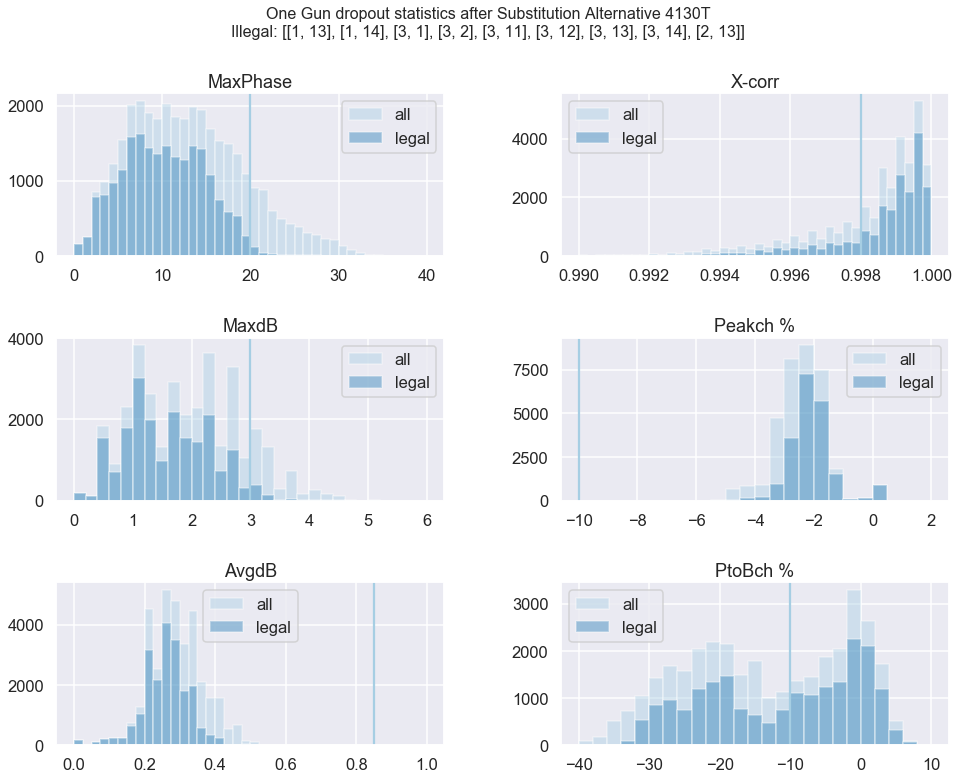

In [463]:
figplot(2, stat_one_gun_bb_raw, stat_one_gun_bb_legal, stat_one_gun_cc_raw, stat_one_gun_cc_legal, 'One Gun dropout statistics after Substitution Alternative 4130T\nIllegal: ' + str(illegal_one_gun))


#### Above plot comments
Single gun dropouts are a lot more likely than two gun dropouts.
The Master Matrix rule is rejecting practically all bad combinations, according to traditional specs
Note: Spares not enabled

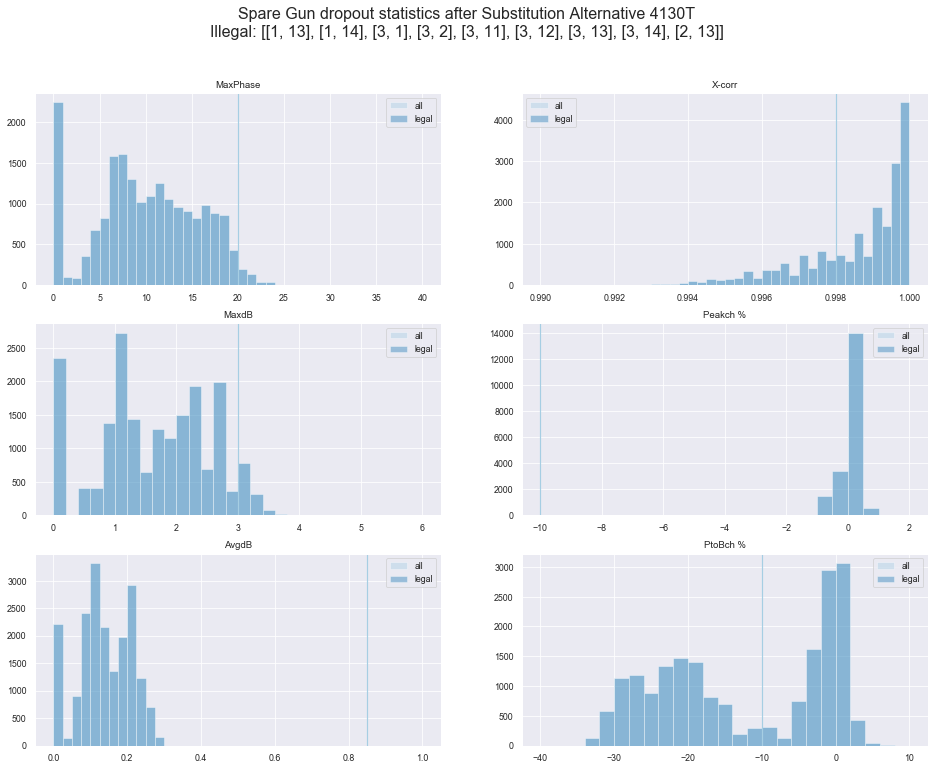

In [411]:
figplot(3, stat_spare_gun_bb_raw, stat_spare_gun_bb_legal, stat_spare_gun_cc_raw, stat_spare_gun_cc_legal, 'Spare Gun dropout statistics after Substitution Alternative 4130T\nIllegal: ' + str(illegal_one_gun))


#### Above plot comments
All spare substitutions allowed, so light blue bars are completely obscures by darker blue bars.
We observe some substitutions that for some parameter combinations could be problematic.

For more in depth analysis and fancier plots (using Pyhton Seaborn module), we join the datasets. First, we'll strip off some columns before the join and add columns for Scenario (which can have the following values: "One gun dropoout", "Two gun dropout" and "Spare substitution") and for Status (which can have the following values: "All" or "Legal"). At the end, all the data are concatenated to a dataset (panda dataframe) called comb_data_bb (bb reflecting that this is the broadband dataset)

In [412]:
strip_one_gun_bb_all = stat_one_gun_bb_raw.drop(columns=['filename'])
strip_one_gun_bb_all['Scenario'] = "One gun dropout"
strip_one_gun_bb_all['Status'] = "All"
strip_one_gun_bb_legal = stat_one_gun_bb_legal.drop(columns=['filename'])
strip_one_gun_bb_legal['Scenario'] = "One gun dropout"
strip_one_gun_bb_legal['Status'] = "Legal"
strip_spare_gun_bb_all = stat_spare_gun_bb_raw.drop(columns=['filename'])
strip_spare_gun_bb_all['Scenario'] = "Spare substitution"
strip_spare_gun_bb_all['Status'] = "All"
strip_spare_gun_bb_legal = stat_spare_gun_bb_legal.drop(columns=['filename'])
strip_spare_gun_bb_legal['Scenario'] = "Spare substitution"
strip_spare_gun_bb_legal['Status'] = "Legal"
comb_data_bb = pd.concat([strip_one_gun_bb_all, strip_one_gun_bb_legal, strip_spare_gun_bb_all, strip_spare_gun_bb_legal], ignore_index=True)

In [413]:
print(comb_data_bb.head())
print(comb_data_bb.tail())

   AvgdB  Depth  MaxPhase  MaxdB         Scenario Status  Subsep  \
0   0.10     40       8.2    1.7  One gun dropout    All      80   
1   0.39     40      11.1    2.3  One gun dropout    All      80   
2   0.27     40      14.1    2.0  One gun dropout    All      80   
3   0.27     40      14.4    2.1  One gun dropout    All      80   
4   0.21     40       8.5    1.7  One gun dropout    All      80   

  Substscenario  Temperature  droparray1  droparray2  dropgun1 dropgun1_str  \
0            00            5           0         NaN         0           00   
1            00            5           1         NaN         2           02   
2            00            5           1         NaN         3           03   
3            00            5           1         NaN         4           04   
4            00            5           1         NaN         5           05   

   dropgun2 dropgun2_str  gunvolume1  gunvolume2  
0       NaN          NaN           0         NaN  
1       NaN   

Then we repeat the process for the cc data (cross-correlation)

In [414]:
strip_one_gun_cc_all = stat_one_gun_cc_raw.drop(columns=['filename'])
strip_one_gun_cc_all['Scenario'] = "One gun dropout"
strip_one_gun_cc_all['Status'] = "All"
strip_one_gun_cc_legal = stat_one_gun_cc_legal.drop(columns=['filename'])
strip_one_gun_cc_legal['Scenario'] = "One gun dropout"
strip_one_gun_cc_legal['Status'] = "Legal"
strip_spare_gun_cc_all = stat_spare_gun_cc_raw.drop(columns=['filename'])
strip_spare_gun_cc_all['Scenario'] = "Spare substitution"
strip_spare_gun_cc_all['Status'] = "All"
strip_spare_gun_cc_legal = stat_spare_gun_cc_legal.drop(columns=['filename'])
strip_spare_gun_cc_legal['Scenario'] = "Spare substitution"
strip_spare_gun_cc_legal['Status'] = "Legal"
comb_data_cc = pd.concat([strip_one_gun_cc_all, strip_one_gun_cc_legal, strip_spare_gun_cc_all, strip_spare_gun_cc_legal], ignore_index=True)
print(comb_data_cc.head())
print(comb_data_cc.tail())

   AvgdB  Depth  MaxdB  Peak  Peakch  PtoB  PtoBch         Scenario Status  \
0   0.19     40    0.8  68.2     0.1  29.6   -17.6  One gun dropout    All   
1   0.41     40    1.3  65.4    -3.9  29.4   -18.1  One gun dropout    All   
2   0.37     40    1.8  66.5    -2.3  28.8   -19.6  One gun dropout    All   
3   0.36     40    1.9  66.5    -2.4  28.6   -20.3  One gun dropout    All   
4   0.22     40    0.9  67.2    -1.3  28.9   -19.6  One gun dropout    All   

   Subsep   ...   Temperature  droparray1  droparray2  dropgun1  dropgun1_str  \
0      80   ...             5           0         NaN         0            00   
1      80   ...             5           1         NaN         2            02   
2      80   ...             5           1         NaN         3            03   
3      80   ...             5           1         NaN         4            04   
4      80   ...             5           1         NaN         5            05   

  dropgun2  dropgun2_str gunvolume1  gunvolu

Just checking the size of the datasets (cc and bb datasets should have same length since both have same number of combinations)

In [415]:
print("all datasets:")
print(len(strip_one_gun_bb_all), len(strip_spare_gun_bb_all))
print(len(strip_one_gun_cc_all), len(strip_spare_gun_cc_all))
print("legal dataset:")
print(len(strip_one_gun_bb_legal), len(strip_spare_gun_bb_legal))
print(len(strip_one_gun_cc_legal), len(strip_spare_gun_cc_legal))

all datasets:
34560 19440
34560 19440
legal dataset:
20520 19440
20520 19440


Combining data using a join (left join, adding a suffix of "-cc" to identical column names, then dropping some redundant columns)

In [416]:
comb_data = comb_data_bb.join(comb_data_cc, rsuffix="-cc").drop(columns=['Scenario-cc', 'Status-cc', 'Depth-cc', 'Subsep-cc', 'Temperature-cc', 'droparray1-cc', 'droparray2-cc', 'dropgun1-cc', 'dropgun2-cc', 'gunvolume1-cc', 'gunvolume2-cc', 'dropgun1_str-cc', 'dropgun2_str-cc', 'Substscenario-cc'])
                                                                       
                                                                         

In [417]:
print(comb_data.columns)

Index(['AvgdB', 'Depth', 'MaxPhase', 'MaxdB', 'Scenario', 'Status', 'Subsep',
       'Substscenario', 'Temperature', 'droparray1', 'droparray2', 'dropgun1',
       'dropgun1_str', 'dropgun2', 'dropgun2_str', 'gunvolume1', 'gunvolume2',
       'AvgdB-cc', 'MaxdB-cc', 'Peak', 'Peakch', 'PtoB', 'PtoBch', 'x-corr'],
      dtype='object')


In [418]:
#comb_data['drop_arr_gun_1'] = str(comb_data['droparray1']['dropgun1'])
#comb_data['drop_arr_gun_1'] = comb_data.droparray1.astype(str).str.cat(comb_data.dropgun1.astype(str), sep='_')
#comb_data['drop_arr_gun_2'] = comb_data.droparray2.astype(str).str.cat(comb_data.dropgun2.astype(str), sep='_')
comb_data['drop_arr_gun_1'] = comb_data.droparray1.astype(str).str.cat(comb_data.dropgun1_str, sep='_')
comb_data['drop_arr_gun_2'] = comb_data.droparray2.astype(str).str.cat(comb_data.dropgun2_str, sep='_')

Inspecting some data. Note that the columns AvgdB and MaxdB contain data from the broadband modeling, whereas AvgdB-cc and MaxdB-cc contains the conventional spec values.

In [419]:
#print(len(comb_data))
#print(comb_data.tail())
print(comb_data['drop_arr_gun_1'].tail())

93955    2_13
93956    2_14
93957    3_11
93958    3_12
93959    3_13
Name: drop_arr_gun_1, dtype: object


Split up the full dataframe in two separate dateaframes: one for legal combinations, one for all combinations.
The comb_data dataframe contain both "all" and "legal" combinations. Convenient when plotting with "hue"
The comb_data_legal contain only status = "legal"
The comb_data_all contain only status "All"

In [420]:
comb_data_legal = comb_data.loc[comb_data['Status'] == "Legal"]
comb_data_all = comb_data.loc[comb_data['Status'] == "All"]

In [421]:
print(len(comb_data))
print(len(comb_data_all))
print(len(comb_data_legal))

93960
54000
39960


## Box Plot
The box plot (also known as a box-and-whisker plot) can tell us about how our dataset is distributed. It shows us the range of our dataset, gives us an idea about where a significant portion of our data lies, and whether or not any outliers are present.

How to interpret a box plot:

-The box represents the interquartile range (The difference between the upper and lower quartiles (Q3–Q1) of a data set. This range is used as a measure of data spread: spanning 50% of a data set and eliminating the influence of outliers (the highest and lowest quarters of a data set are removed).) 

-The line in the middle of the box is the median

-The end lines are the first and third quartiles (In order to determine the interquartile range, a data set is divided into four equal parts. Each separating value is called a quartile (the first, the second, etc.). The second quartile is the median)

-The diamonds show outliers


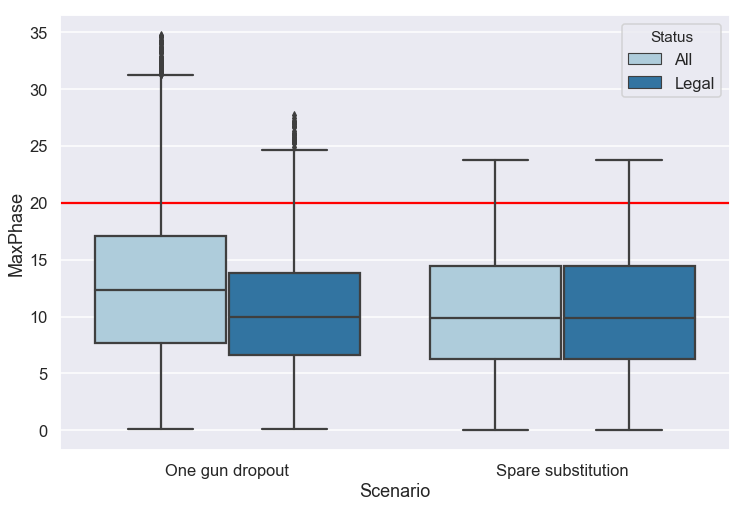

In [459]:
sns.set_style("darkgrid")
sns.set_palette("pastel")
sns.set_context("talk")
sns.set_palette("Paired")
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.boxplot(data=comb_data, x='Scenario', y='MaxPhase', hue='Status');

For reference the 20 degree maxphase limit is plotted as a red line.
Observations:

One gun dropout (which is far more likely than two gun dropouts): All legal (master matrix filtered) or 100% of combinations are within the 20 phase spec

Two gun dropouts: More than 75% of legal dropouts are within spec

Spare gun dropouts: More than 75% of legal dropouts are within spec

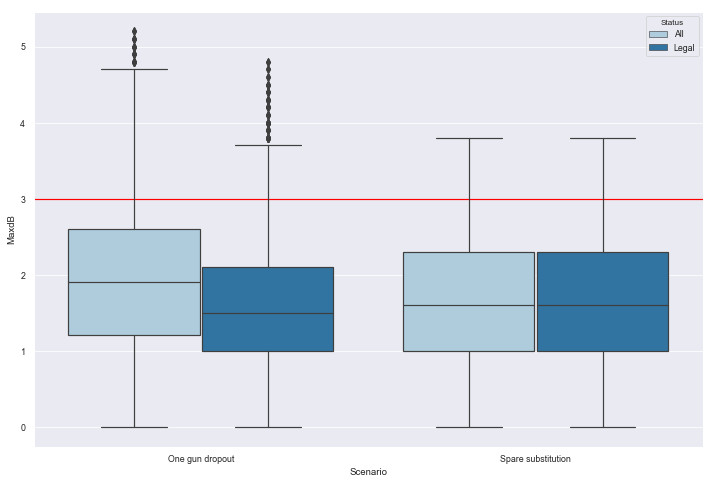

In [423]:
plt.figure(figsize=(12,8))
plt.axhline(3, color='red')
sns.boxplot(data=comb_data, x='Scenario', y='MaxdB', hue='Status');

## Violin Plots
Violin plots provide more information than box plots because instead of mapping each individual data point, we get an estimation of the dataset from the KDE (Kernel Density Estimation).

There are two KDE plots that are symmetrical along the center line.
A white dot represents the median.
The thick black line in the center of each violin represents the interquartile range.
The lines that extend from the center are the confidence intervals - just on the box plots, a violin plot also displays the 95% confidence interval.

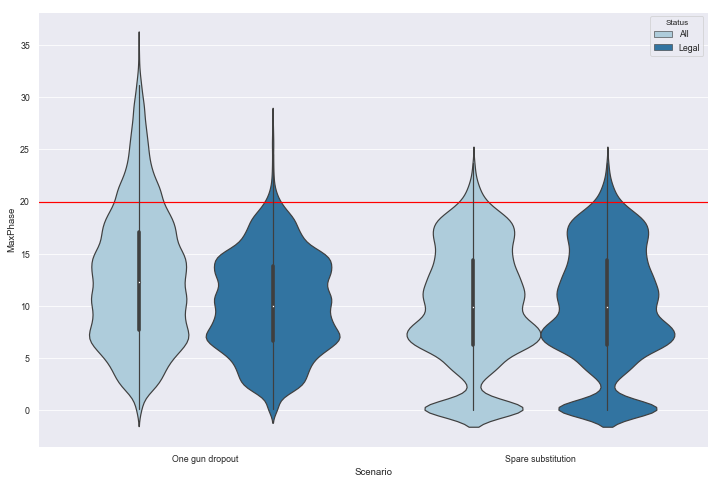

In [424]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.violinplot(data=comb_data, x='Scenario', y='MaxPhase', hue='Status');

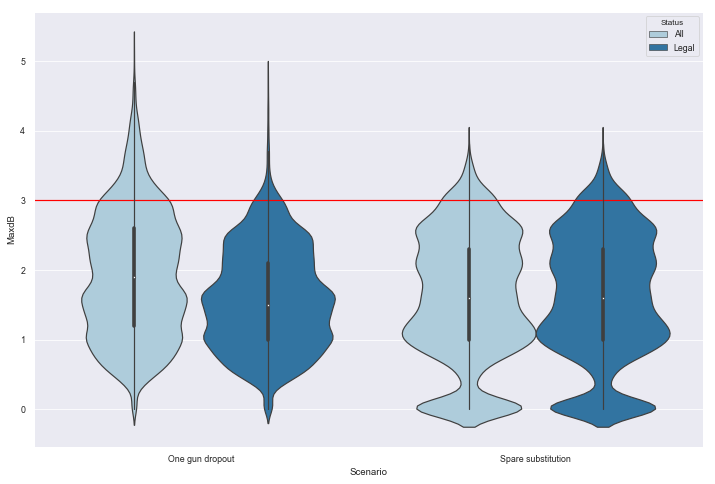

In [425]:
plt.figure(figsize=(12,8))
plt.axhline(3, color='red')
sns.violinplot(data=comb_data, x='Scenario', y='MaxdB', hue='Status');

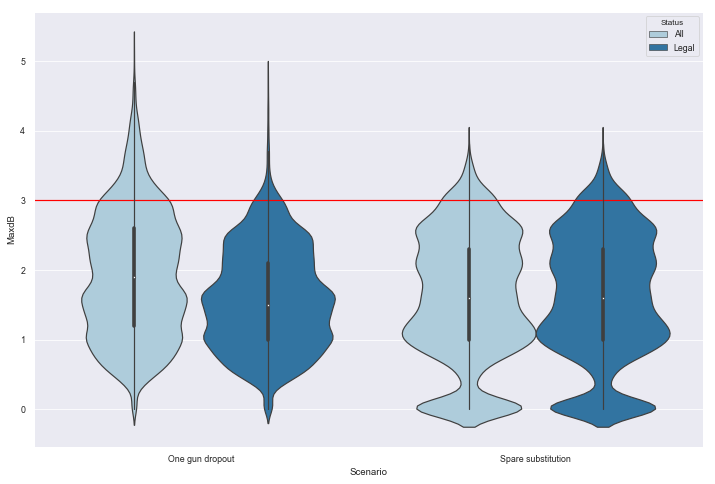

In [426]:
plt.figure(figsize=(12,8))
plt.axhline(3, color='red')
sns.violinplot(data=comb_data, x='Scenario', y='MaxdB', hue='Status');

### Checking correlation between some statistical values
To answer questions like: If x-corr is bad, is always MaxPhase equally bad?
Does traditional broadband specs capture bad combinations also according to other specs?

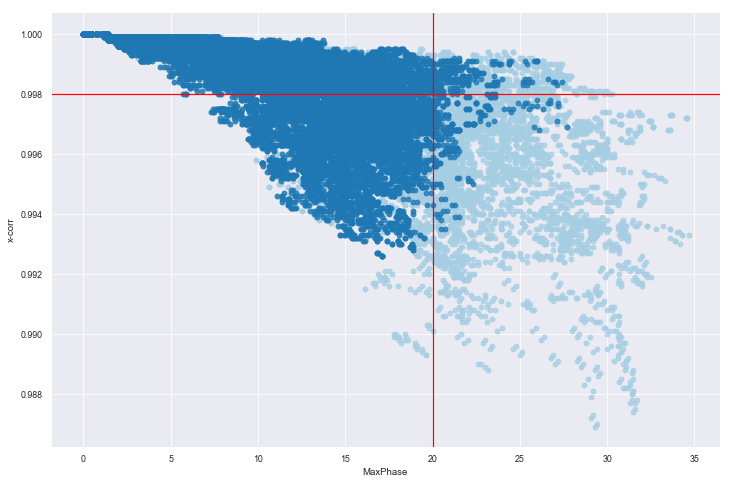

In [427]:
plt.figure(figsize=(12,8))
plt.axhline(0.998, color='red')
plt.axvline(20, color='red')
sns.regplot(x=comb_data_all["MaxPhase"], y=comb_data_all["x-corr"], fit_reg=False)
sns.regplot(x=comb_data_legal["MaxPhase"], y=comb_data_legal["x-corr"], fit_reg=False);

Comment to above figure:
The red spec lines form a 4-field matrix.

Many combinations are bad using both specs (lower right field).

But many combinations that fullfill the x-corr spec, fail the MaxPhase spec (upper right field), also quite significantly (>30 degrees).

Also many combinations that meet the MaxPhase spec fails the x-corr spec (lower left field).

Note that dark dots are still legal combinations according to the MasterMatrix. Light dots are all combinations.

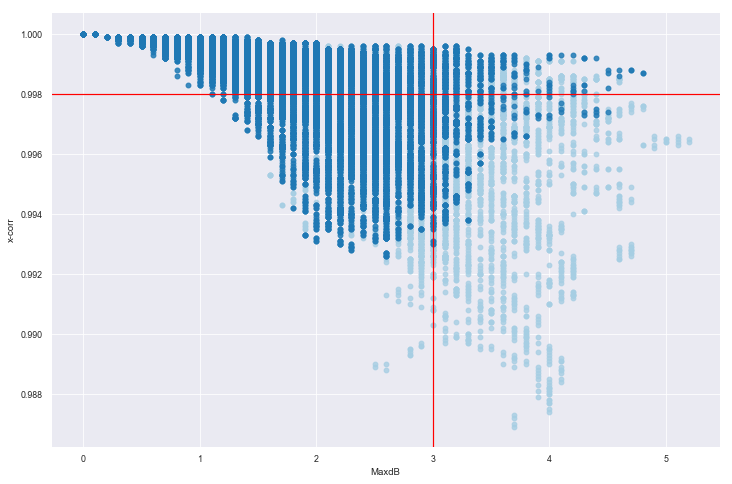

In [428]:
plt.figure(figsize=(12,8))
plt.axhline(0.998, color='red')
plt.axvline(3, color='red')
sns.regplot(x=comb_data_all["MaxdB"], y=comb_data_all["x-corr"], fit_reg=False)
sns.regplot(x=comb_data_legal["MaxdB"], y=comb_data_legal["x-corr"], fit_reg=False);

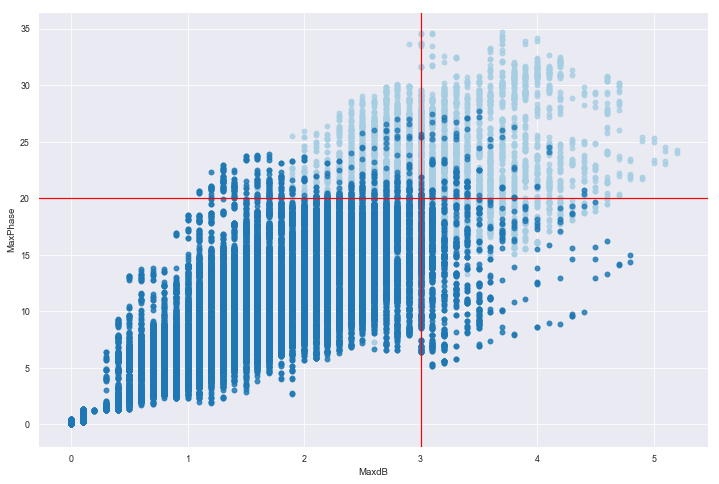

In [429]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
plt.axvline(3, color='red')
sns.regplot(x=comb_data_all["MaxdB"], y=comb_data_all["MaxPhase"], fit_reg=False)
sns.regplot(x=comb_data_legal["MaxdB"], y=comb_data_legal["MaxPhase"], fit_reg=False);

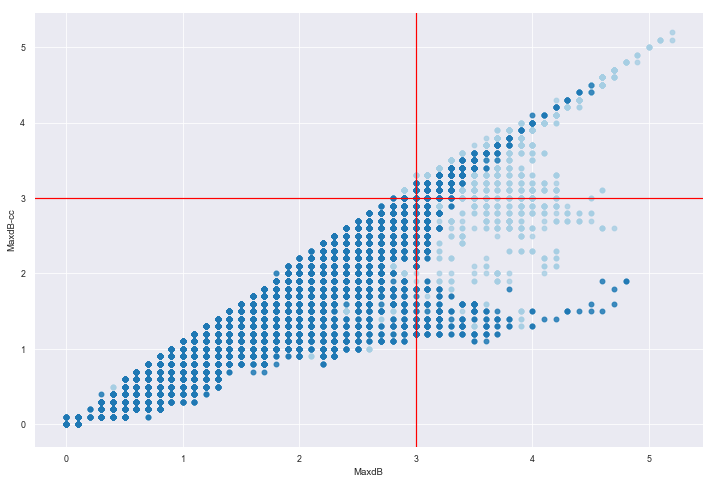

In [430]:
plt.figure(figsize=(12,8))
plt.axhline(3, color='red')
plt.axvline(3, color='red')
sns.regplot(x=comb_data_all["MaxdB"], y=abs(comb_data_all["MaxdB-cc"]), fit_reg=False)
sns.regplot(x=comb_data_legal["MaxdB"], y=abs(comb_data_legal["MaxdB-cc"]), fit_reg=False);

Note: abs(MaxdB-cc) correlates with MaxdB (check why this is different between bb and conventional stats)

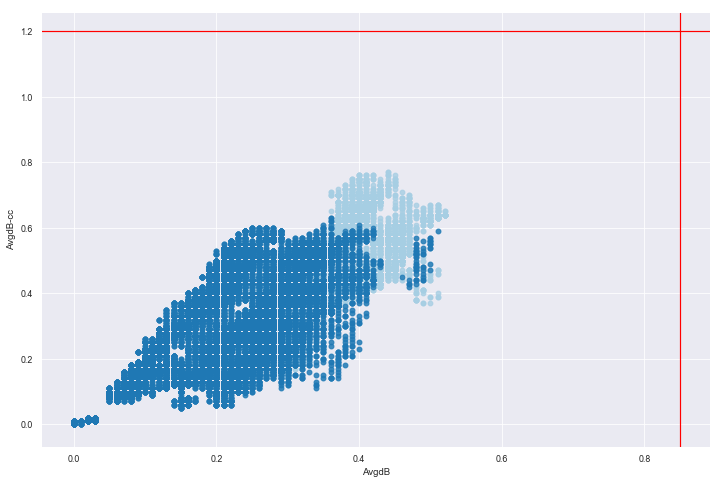

In [431]:
plt.figure(figsize=(12,8))
plt.axhline(1.2, color='red')
plt.axvline(0.85, color='red')
sns.regplot(x=comb_data_all["AvgdB"], y=comb_data_all["AvgdB-cc"], fit_reg=False)
sns.regplot(x=comb_data_legal["AvgdB"], y=comb_data_legal["AvgdB-cc"], fit_reg=False);

## What about traditional sets of specs?
In previous section, we looked at the dependencies between single specs.
So what about traditional sets of specs?

Broadband MC specs (5-200Hz, refl coeff = 0):

<li>AvgdB: 0.85</li>
<li>MaxdB: 3.0</li>
<li>MaxPhase: 20</li>

Conventional (old MC) specs (10-70Hz, refl coeff = -1)

<li>x-corr: 0.998</li>
<li>AvgdB: 1.2</li>
<li>MaxdB: 3.0</li>

Let us apply this rule as filters to the "All" datasets

In [432]:
comb_data_bb_legal = comb_data[(comb_data['AvgdB'] < 0.85) & (comb_data['MaxdB'] < 3) & (comb_data['MaxPhase'] < 20)]




In [433]:
print(len(comb_data))
print(len(comb_data_bb_legal))

93960
83141


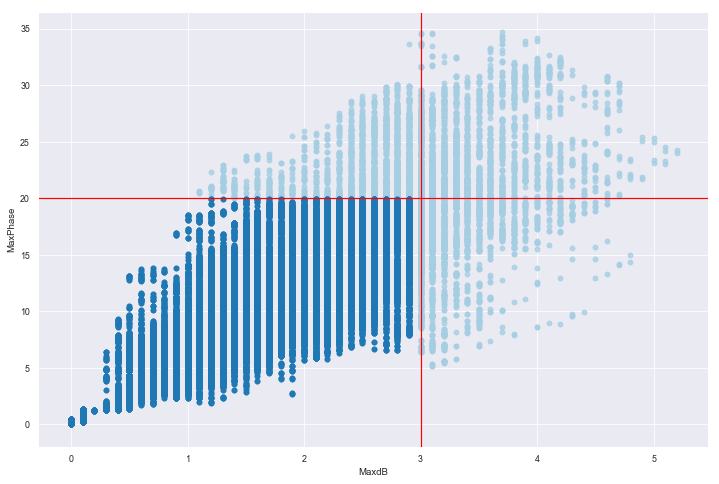

In [434]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
plt.axvline(3, color='red')
sns.regplot(x=comb_data_all["MaxdB"], y=comb_data_all["MaxPhase"], fit_reg=False)
sns.regplot(x=comb_data_bb_legal["MaxdB"], y=comb_data_bb_legal["MaxPhase"], fit_reg=False);

In [435]:
comb_data_cc_legal = comb_data[(comb_data['AvgdB-cc'] < 1.2) & (comb_data['MaxdB-cc'] < 3) & (comb_data['x-corr'] > 0.998)]

In [436]:
print(len(comb_data))
print(len(comb_data_cc_legal))

93960
65796


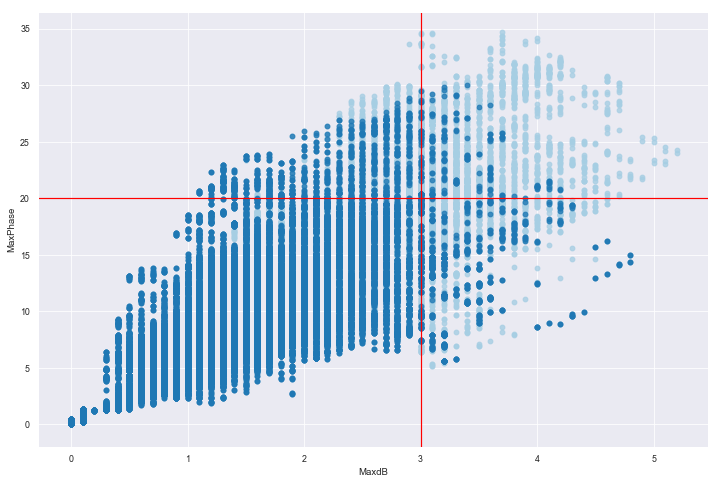

In [437]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
plt.axvline(3, color='red')
sns.regplot(x=comb_data_all["MaxdB"], y=comb_data_all["MaxPhase"], fit_reg=False)
sns.regplot(x=comb_data_cc_legal["MaxdB"], y=comb_data_cc_legal["MaxPhase"], fit_reg=False);

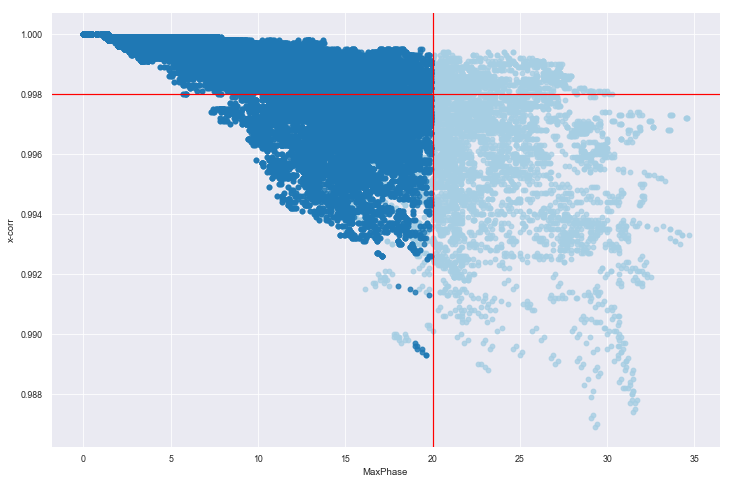

In [438]:
plt.figure(figsize=(12,8))
plt.axhline(0.998, color='red')
plt.axvline(20, color='red')
sns.regplot(x=comb_data_all["MaxPhase"], y=comb_data_all["x-corr"], fit_reg=False)
sns.regplot(x=comb_data_bb_legal["MaxPhase"], y=comb_data_bb_legal["x-corr"], fit_reg=False);

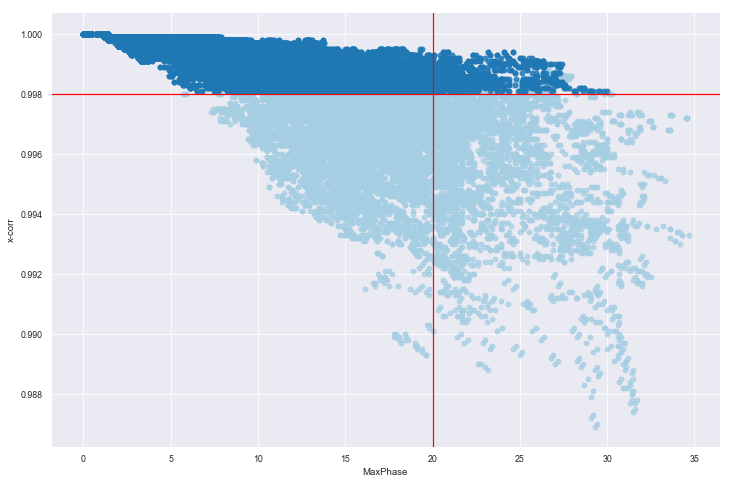

In [439]:
plt.figure(figsize=(12,8))
plt.axhline(0.998, color='red')
plt.axvline(20, color='red')
sns.regplot(x=comb_data_all["MaxPhase"], y=comb_data_all["x-corr"], fit_reg=False)
sns.regplot(x=comb_data_cc_legal["MaxPhase"], y=comb_data_cc_legal["x-corr"], fit_reg=False);

### Checking dependiencies with temperature and depth

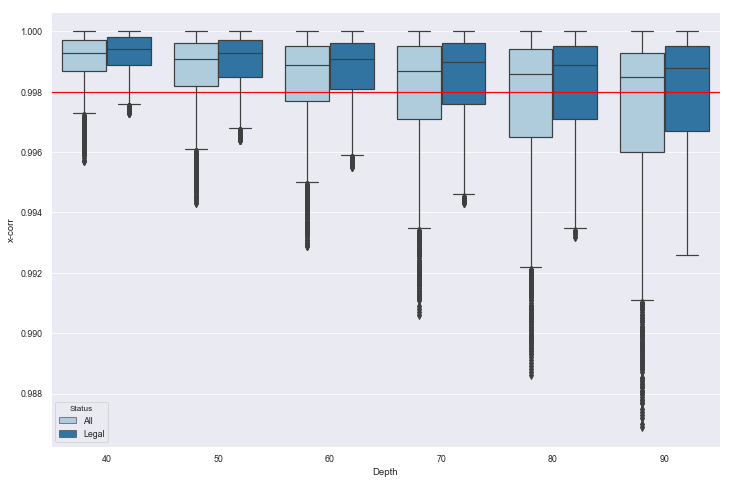

In [440]:
plt.figure(figsize=(12,8))
plt.axhline(0.998, color='red')
sns.boxplot(data=comb_data, x='Depth', y='x-corr', hue='Status');

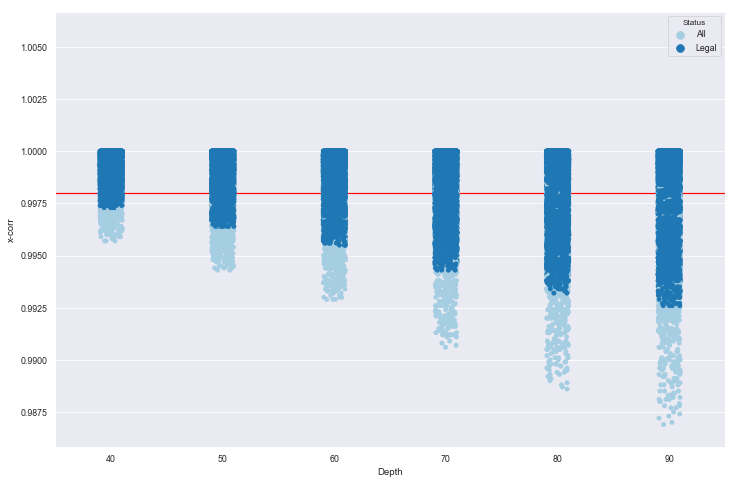

In [441]:
plt.figure(figsize=(12,8))
plt.axhline(0.998, color='red')
sns.stripplot(x=comb_data["Depth"], y=comb_data["x-corr"], hue=comb_data['Status']);

Not that this plot could be misleading wrt distribution (many dots on top of eachother), box plot shown previously mitigates this.

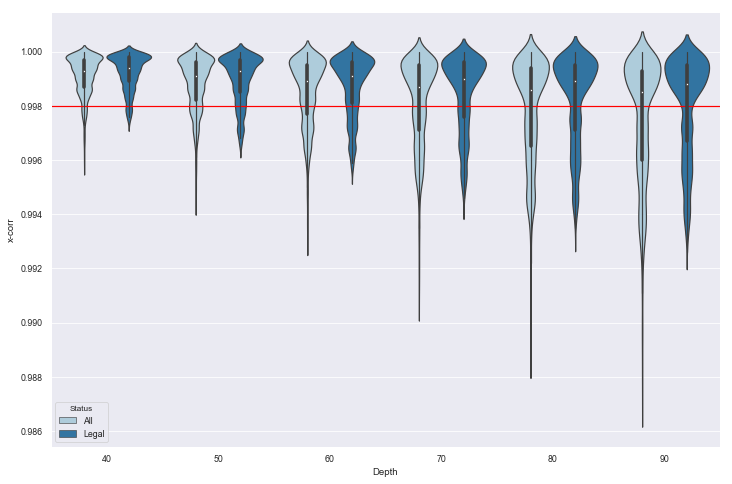

In [442]:
plt.figure(figsize=(12,8))
plt.axhline(0.998, color='red')
sns.violinplot(data=comb_data, x='Depth', y='x-corr', hue='Status');

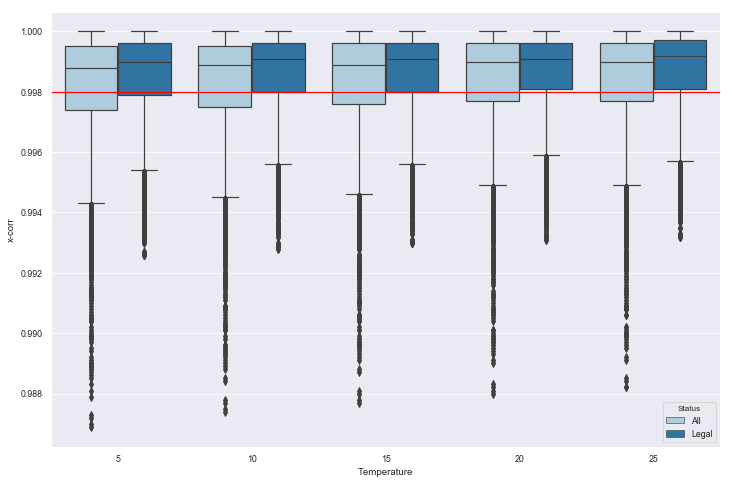

In [443]:
plt.figure(figsize=(12,8))
plt.axhline(0.998, color='red')
sns.boxplot(data=comb_data, x='Temperature', y='x-corr', hue='Status');

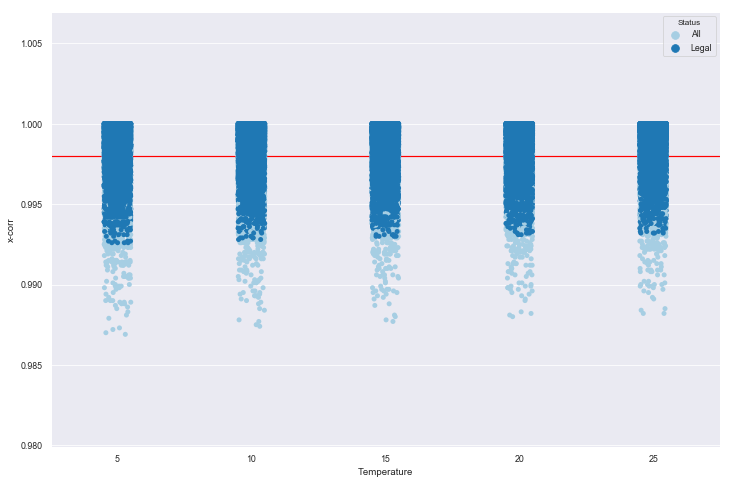

In [444]:
plt.figure(figsize=(12,8))
plt.axhline(0.998, color='red')
sns.stripplot(x=comb_data["Temperature"], y=comb_data["x-corr"], hue=comb_data['Status']);

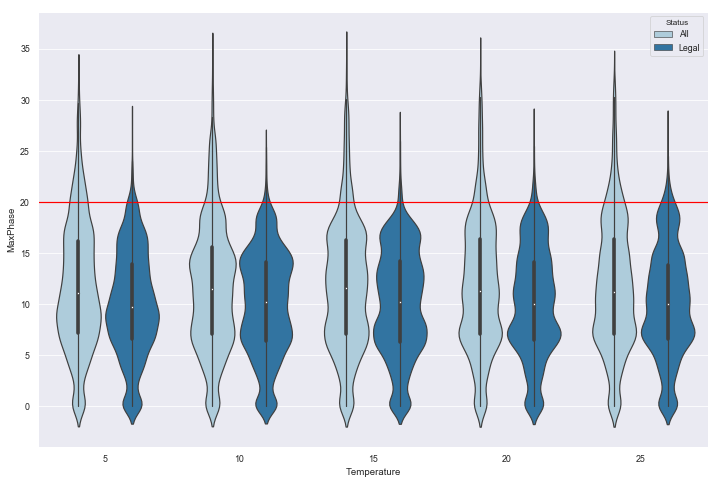

In [445]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.violinplot(data=comb_data, x='Temperature', y='MaxPhase', hue='Status');

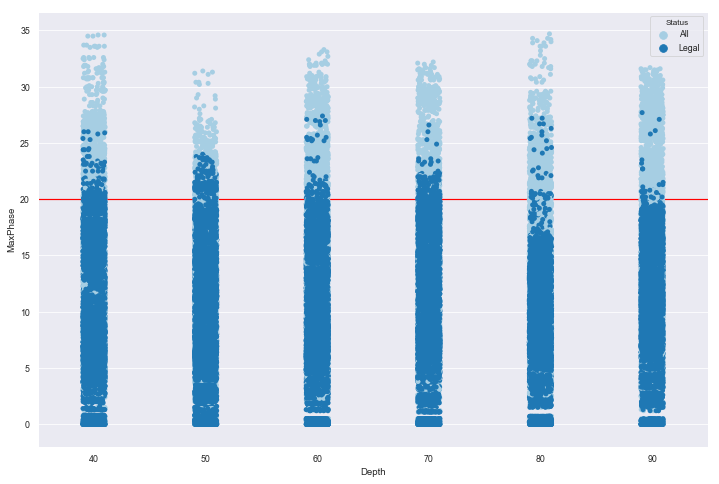

In [446]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.stripplot(data=comb_data, x='Depth', y='MaxPhase', hue='Status');

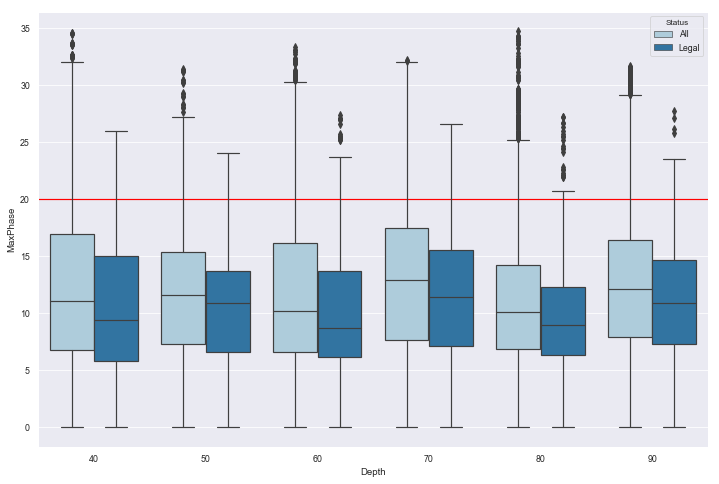

In [447]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.boxplot(data=comb_data, x='Depth', y='MaxPhase', hue='Status');

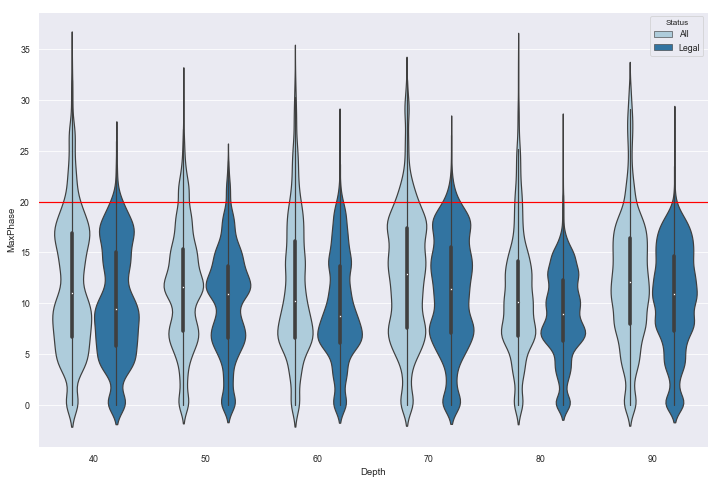

In [448]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.violinplot(data=comb_data, x='Depth', y='MaxPhase', hue='Status');

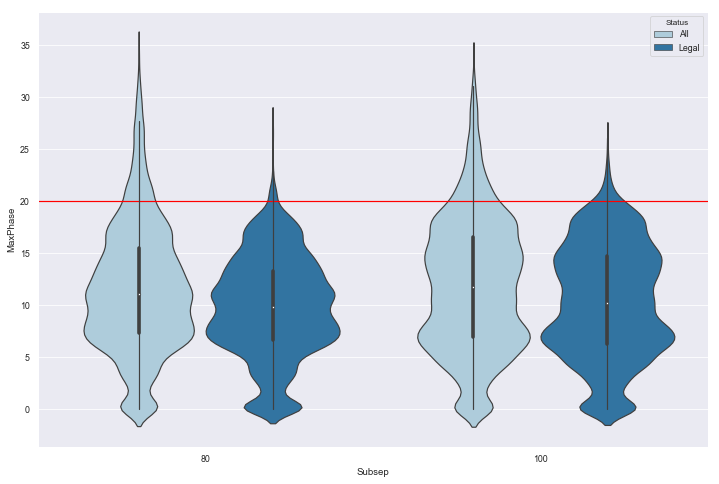

In [449]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.violinplot(data=comb_data, x='Subsep', y='MaxPhase', hue='Status');

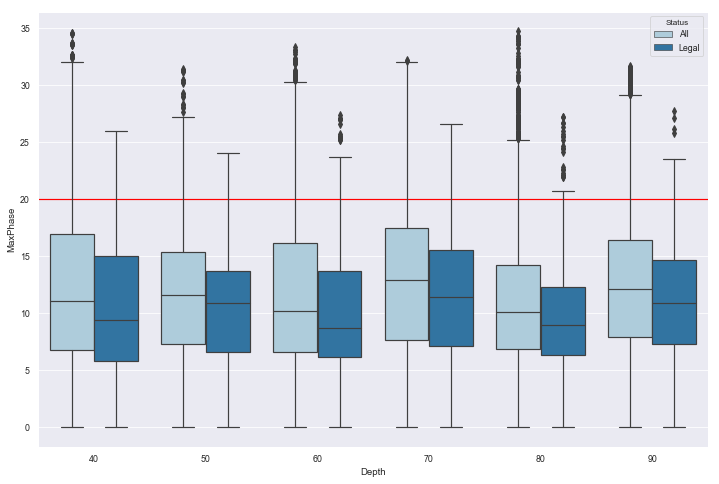

In [450]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.boxplot(data=comb_data, x='Depth', y='MaxPhase', hue='Status');

In [451]:
print(comb_data.columns)

Index(['AvgdB', 'Depth', 'MaxPhase', 'MaxdB', 'Scenario', 'Status', 'Subsep',
       'Substscenario', 'Temperature', 'droparray1', 'droparray2', 'dropgun1',
       'dropgun1_str', 'dropgun2', 'dropgun2_str', 'gunvolume1', 'gunvolume2',
       'AvgdB-cc', 'MaxdB-cc', 'Peak', 'Peakch', 'PtoB', 'PtoBch', 'x-corr',
       'drop_arr_gun_1', 'drop_arr_gun_2'],
      dtype='object')


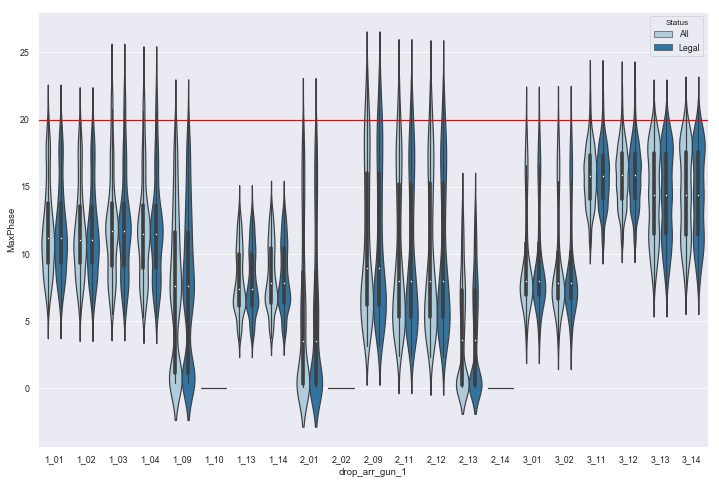

In [452]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.violinplot(data=comb_data[comb_data['Scenario'] == 'Spare substitution'], x='drop_arr_gun_1', y='MaxPhase', hue='Status');

In [453]:
#plt.figure(figsize=(12,8))
#plt.axhline(20, color='red')
#sns.boxplot(data=comb_data[comb_data['Scenario'] == 'Spare substitution'], x='drop_arr_gun_1', y='MaxPhase', hue='drop_arr_gun_2');

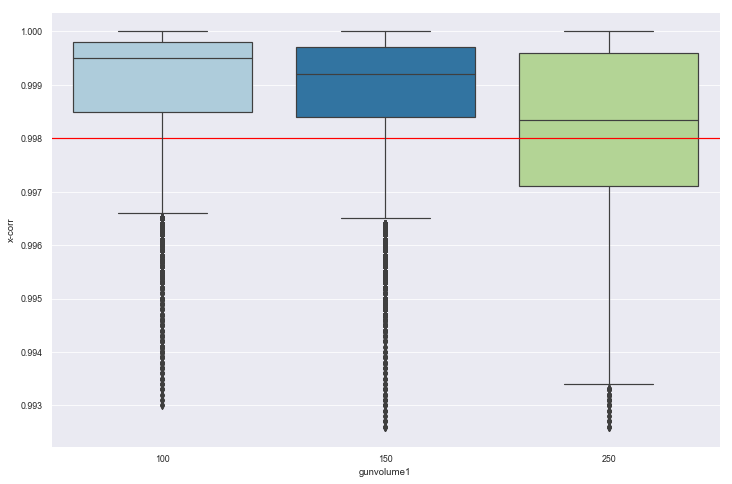

In [454]:
plt.figure(figsize=(12,8))
plt.axhline(0.998, color='red')
sns.boxplot(data=comb_data[comb_data['Scenario'] == 'Spare substitution'], x='gunvolume1', y='x-corr');

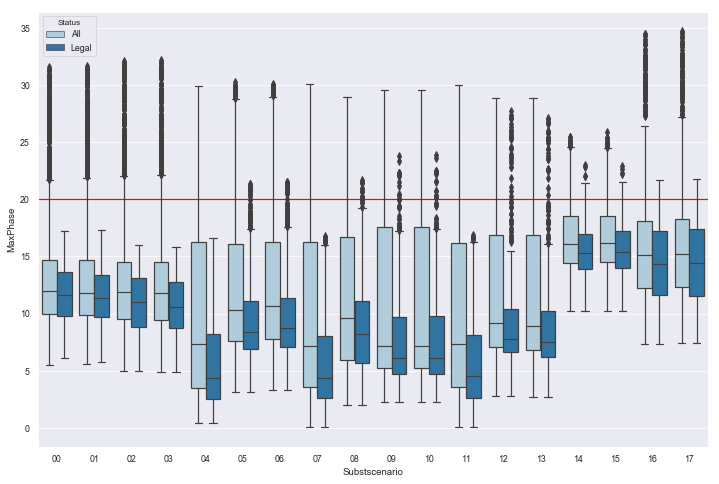

In [455]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.boxplot(data=comb_data[comb_data['Scenario'] == 'One gun dropout'], x='Substscenario', y='MaxPhase', hue='Status');

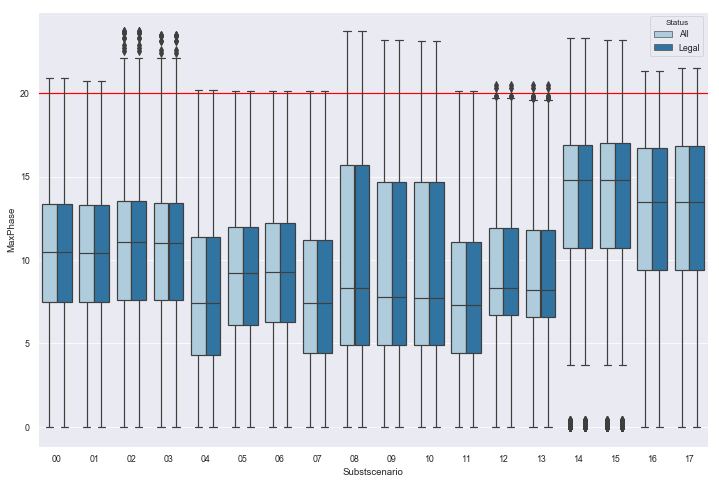

In [456]:
plt.figure(figsize=(12,8))
plt.axhline(20, color='red')
sns.boxplot(data=comb_data[comb_data['Scenario'] == 'Spare substitution'], x='Substscenario', y='MaxPhase', hue='Status');

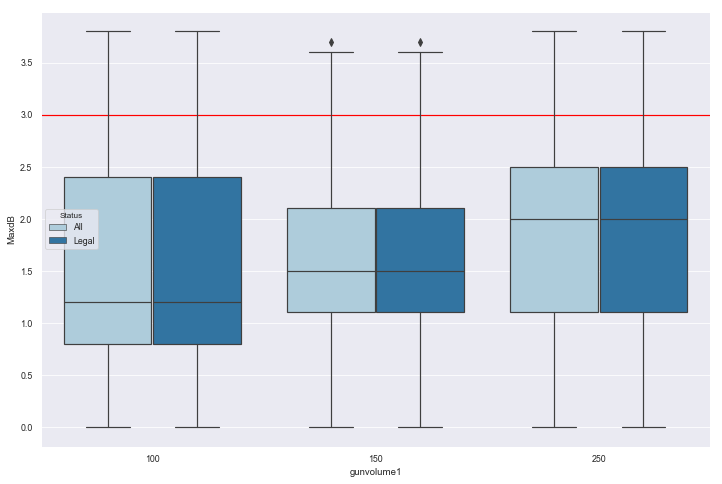

In [457]:
plt.figure(figsize=(12,8))
plt.axhline(3, color='red')
sns.boxplot(data=comb_data[comb_data['Scenario'] == 'Spare substitution'], x='gunvolume1', y='MaxdB', hue='Status');

In [458]:
print(comb_data.columns)

Index(['AvgdB', 'Depth', 'MaxPhase', 'MaxdB', 'Scenario', 'Status', 'Subsep',
       'Substscenario', 'Temperature', 'droparray1', 'droparray2', 'dropgun1',
       'dropgun1_str', 'dropgun2', 'dropgun2_str', 'gunvolume1', 'gunvolume2',
       'AvgdB-cc', 'MaxdB-cc', 'Peak', 'Peakch', 'PtoB', 'PtoBch', 'x-corr',
       'drop_arr_gun_1', 'drop_arr_gun_2'],
      dtype='object')
